In [2]:
import numpy as np
#from ptsa.data.filters.morlet import MorletWaveletFilter
from ptsa.data.readers import EEGReader
from ptsa.data.filters import MonopolarToBipolarMapper
from ptsa.data.filters import ResampleFilter
from ptsa.data.filters import ButterworthFilter
# from ptsa.data.readers.TalReader import TalReader
from ptsa.data.readers import TalReader
# from ptsa.data.readers.IndexReader import JsonIndexReader
from ptsa.data.readers import JsonIndexReader
from ptsa.data.readers import BaseEventReader
from ptsa.data.TimeSeriesX import TimeSeriesX as TimeSeries
import h5py
#from exceptions import OSError
import os
import mne
from glob import glob




In [3]:
rhino_mount = ''
jr = JsonIndexReader(rhino_mount + '/protocols/ltp.json')
exp = 'ltpFR2'

In [14]:
jr?

Type:           JsonIndexReader
String form:    <ptsa.data.readers.index.JsonIndexReader object at 0x2ae67c4f4518>
File:           ~/anaconda3/envs/PTSA/lib/python3.6/site-packages/ptsa/data/readers/index.py
Docstring:     
Reads from one of the top level indexing files (r1.json, ltp.json)
Allows for aggregation of values across any field with any constraint through the use of aggregateValues() or the
specific methods subject(), experiment(), session() or montage().
Init docstring:
Constructor.
Reads from the passed in index file, and appends the root of the index files to anything that
appears to be a path
:param protocols: 'r1', 'ltp'


In [4]:
evs = []

bad_subjsess_files = [
    rhino_mount+
    '/protocols/ltp/subjects/LTP326/experiments/ltpFR2/sessions/19/behavioral/current_processed/task_events.json']

for f in sorted(jr.aggregate_values('task_events', experiment=exp)):
    if f in bad_subjsess_files:
        continue
    tmpev = BaseEventReader(filename=f).read()
    if len(tmpev) == 0:
        continue
    # only use BioSemi events
    if tmpev['eegfile'][0].split('.')[-1] != 'bdf':
        continue
    else:
        # only use encoding events:
        tmpev = tmpev[tmpev['type'] == 'WORD']
        evs.append(tmpev)
evs = np.concatenate(evs)

evs['eegfile'] = np.array([rhino_mount+ef for ef in evs['eegfile']])


In [23]:
np.unique(evs['montage'])

array(['0.0'], dtype='<U256')

In [5]:
channels = ['A'+str(i) for i in range(1, 33)]
channels.extend(['B'+str(i) for i in range(1, 33)])
channels.extend(['C'+str(i) for i in range(1, 33)])
channels.extend(['D'+str(i) for i in range(1, 33)])

channels = np.array(channels)
channels

array(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20',
       'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29',
       'A30', 'A31', 'A32', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
       'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17',
       'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26',
       'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'C1', 'C2', 'C3', 'C4',
       'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23',
       'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32',
       'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11',
       'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20',
       'D21', 'D22', 'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29',
       'D30', 'D31', 'D32'], dtype='<U3')

In [10]:
start_time = -0.2
end_time = 1.0
buf_time = 0.0

In [6]:
def get_raw_eeg(subj, sess):
    eegpath = (rhino_mount+'/protocols/ltp/subjects/'+subj+
               '/experiments/ltpFR2/sessions/'+str(sess)+
               '/ephys/current_processed/')
    sys = 'bio' if int(subj[-3:]) > 330 else 'egi'
    if sys == 'bio':
        eegfile = glob(eegpath+'*.bdf')
        if len(eegfile)!=1:
            return
        eegfile = eegfile[0]
        raw = mne.io.read_raw_edf(eegfile, eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'], 
                                  misc=['EXG5', 'EXG6', 'EXG7', 'EXG8'], 
                                  stim_channel='Status', 
                                  montage='biosemi128', 
                                  preload=True) # needs to be true for 0.1Hz high-pass filter to work

    else:
        # for now catch this case -- different pipeline for EGI subjects!
        raise ValueError('EGI subject!')
        eegfile = (glob(eegpath+'*.2.raw') + glob(eegpath+'*.1.raw') +
                   glob(eegpath+'*.mff'))
        if len(eegfile)!=1:
            return
        eegfile = eegfile[0]
        raw = mne.io.read_raw_egi(eegfile, preload=True)
        raw.rename_channels({'E129': 'Cz'})
        raw.set_montage(mne.channels.read_montage('GSN-HydroCel-129'))
        raw.set_channel_types({'E8': 'eog', 'E25': 'eog', 'E126': 'eog',
                               'E127': 'eog', 'Cz': 'misc'})
        
    # get bad channels - new version
    badchanfile = glob(eegpath+'*_bad_chan.txt')
    if len(badchanfile) > 0:
        with open(badchanfile[0], 'r') as f:
            bad = [s.strip() for s in f.readlines()]
        raw.info['bads'] = bad
    # 0.1Hz high-pass filter
    raw.filter(l_freq=0.1, h_freq=None, method='iir', iir_params=None)
    return raw

In [7]:
subj = evs['subject'][0]
sess = evs['session'][0]

In [8]:
dat=get_raw_eeg(subj, sess)

Extracting EDF parameters from /protocols/ltp/subjects/LTP331/experiments/ltpFR2/sessions/0/ephys/current_processed/LTP331_session_0.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12107775  =      0.000 ...  5912.000 secs...
Setting up high-pass filter at 0.1 Hz


In [11]:
def create_epoch(raw, events, start_time=start_time,
                 end_time=end_time, buf_time=buf_time):
    mne_events = np.zeros((len(events), 3), dtype=int)
    mne_events[:, 0] = events['eegoffset']
    ep = mne.Epochs(raw, mne_events, tmin=start_time-buf_time,
                    tmax=end_time+buf_time, baseline=None, preload=True)
    # convert to microvolts, average reference
    ep._data = ep._data * 1000000
    ep.set_eeg_reference('average', projection=False)

    ep.pick_types(eeg=True, exclude=[])
    # # - resample
    # ep.resample(500.0)
    return ep



In [13]:
subjfilt = evs['subject'] == subj
sessfilt = evs['session'] == sess
dat = create_epoch(dat, events=evs[subjfilt & sessfilt],
                   start_time=start_time,
                   end_time=end_time, buf_time=buf_time)
dat = TimeSeries(dat._data, dims=('events','channels','time'),
                 coords={'events': evs[subjfilt & sessfilt], 
                         'channels': dat.info['ch_names'], 
                         'time': dat.times,
                         'samplerate': dat.info['sfreq']})


576 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 576 events and 2459 original time points ...
0 bad epochs dropped
Applying average reference.
Applying a custom EEG reference.


In [14]:
dat

<xarray.TimeSeriesX (events: 576, channels: 128, time: 2459)>
array([[[ -0.396328,  -2.007153, ...,   7.611448,   7.28664 ],
        [ -7.524218,  -8.696657, ...,  -4.800465,  -3.906373],
        ...,
        [ -2.709054,  -2.656746, ..., -19.420009, -20.363116],
        [ -6.234364,  -4.355129, ...,  24.228725,  23.734813]],

       [[  1.022116,   2.474697, ...,  -1.143036,  -0.985908],
        [  1.95798 ,   1.784579, ...,   7.272733,   6.897204],
        ...,
        [-10.893025, -11.903706, ...,  20.002299,  18.914087],
        [ 25.173282,  22.484499, ..., -22.580421, -22.660712]],

       ...,

       [[  1.356298,   1.054923, ...,   9.437575,  10.02151 ],
        [  1.138747,   1.96411 , ...,   9.176513,   9.824518],
        ...,
        [  8.515531,   8.651153, ...,   9.525339,  10.670418],
        [ -2.147861,   0.396645, ...,   1.994784,  -0.045593]],

       [[ -1.958529,  -1.466091, ...,   1.002504,   0.614769],
        [  4.208517,   2.296452, ...,   4.130437,   3.369708]

In [26]:
dat -= dat.sel(time=dat['time']<0).mean('time')

In [33]:
dat

<xarray.TimeSeriesX (events: 576, channels: 128, time: 2459)>
array([[[  3.443741,   1.832915, ...,  11.451516,  11.126709],
        [  2.839841,   1.667402, ...,   5.563594,   6.457687],
        ...,
        [  3.632159,   3.684467, ..., -13.078795, -14.021902],
        [ -2.17386 ,  -0.294625, ...,  28.289229,  27.795317]],

       [[ -1.542187,  -0.089606, ...,  -3.707338,  -3.550211],
        [ -4.457799,  -4.6312  , ...,   0.856954,   0.481425],
        ...,
        [ -2.560272,  -3.570953, ...,  28.335052,  27.246839],
        [ 23.872326,  21.183544, ..., -23.881376, -23.961667]],

       ...,

       [[  7.615629,   7.314255, ...,  15.696906,  16.280842],
        [  5.522757,   6.34812 , ...,  13.560523,  14.208528],
        ...,
        [  4.306975,   4.442597, ...,   5.316783,   6.461861],
        [  1.94559 ,   4.490096, ...,   6.088234,   4.047858]],

       [[  0.389808,   0.882246, ...,   3.350842,   2.963107],
        [  2.436364,   0.524299, ...,   2.358284,   1.597555]

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

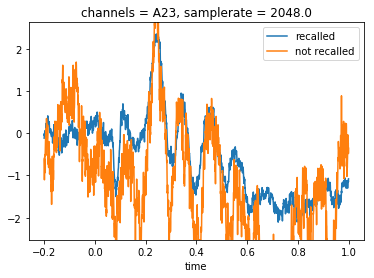

In [43]:
dat.sel(events=dat['events'].values['recalled']==1, channels='A23').mean('events').plot(
    label='recalled')
dat.sel(events=dat['events'].values['recalled']==0, channels='A23').mean('events').plot(
    label='not recalled')
plt.legend()

In [47]:
#dat['events'].values
pd

NameError: name 'pd' is not defined

In [50]:
import pandas as pd
import statsmodels

In [53]:
evs_df = pd.DataFrame.from_records(dat['events'].values)

In [64]:
dat

<xarray.TimeSeriesX (events: 576, channels: 128, time: 2459)>
array([[[  3.443741,   1.832915, ...,  11.451516,  11.126709],
        [  2.839841,   1.667402, ...,   5.563594,   6.457687],
        ...,
        [  3.632159,   3.684467, ..., -13.078795, -14.021902],
        [ -2.17386 ,  -0.294625, ...,  28.289229,  27.795317]],

       [[ -1.542187,  -0.089606, ...,  -3.707338,  -3.550211],
        [ -4.457799,  -4.6312  , ...,   0.856954,   0.481425],
        ...,
        [ -2.560272,  -3.570953, ...,  28.335052,  27.246839],
        [ 23.872326,  21.183544, ..., -23.881376, -23.961667]],

       ...,

       [[  7.615629,   7.314255, ...,  15.696906,  16.280842],
        [  5.522757,   6.34812 , ...,  13.560523,  14.208528],
        ...,
        [  4.306975,   4.442597, ...,   5.316783,   6.461861],
        [  1.94559 ,   4.490096, ...,   6.088234,   4.047858]],

       [[  0.389808,   0.882246, ...,   3.350842,   2.963107],
        [  2.436364,   0.524299, ...,   2.358284,   1.597555]

In [54]:
dat['events'].values.dtype.names

('begin_distractor',
 'begin_math_correct',
 'eegfile',
 'eegoffset',
 'eogArtifact',
 'experiment',
 'final_distractor',
 'final_math_correct',
 'intruded',
 'intrusion',
 'item_name',
 'item_num',
 'montage',
 'msoffset',
 'mstime',
 'protocol',
 'recalled',
 'rectime',
 'serialpos',
 'session',
 'subject',
 'trial',
 'type')

In [59]:
evs_df['final_math_correct'].unique()

array([11, 10,  9, 12, 13])

In [86]:
evs_df.loc[evs_df['session']==0]

KeyError: False

In [ ]:
import statsmodels.formula.api as smf

In [63]:
23/24

0.9583333333333334

In [ ]:
smf.ols(
        'recalled ~ 1 + session + sleep + alertness + hrs_from_noon',
        data=evsessinfo).fit()

In [98]:
576*314752 == 576*128*2459

True

In [100]:
test = dat.stack(features=('channels', 'time'))

In [101]:
test

<xarray.TimeSeriesX (events: 576, features: 314752)>
array([[  3.443741,   1.832915,   2.629897, ...,  28.635745,  28.289229,
         27.795317],
       [ -1.542187,  -0.089606,  -0.774781, ..., -24.372178, -23.881376,
        -23.961667],
       [ -2.692511,  -4.839268,  -6.311028, ..., -16.766538, -17.826848,
        -16.438466],
       ...,
       [  0.77951 ,  -0.158448,  -0.346668, ...,   7.918862,   6.63767 ,
          7.008819],
       [  7.615629,   7.314255,   6.524339, ...,   5.14971 ,   6.088234,
          4.047858],
       [  0.389808,   0.882246,   2.701245, ...,  -9.809904, -10.431235,
         -9.446319]])
Coordinates:
  * events      (events) (numpy.record, [('begin_distractor', '<i8'), ('begin_math_correct', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8'), ('eogArtifact', '<i8'), ('experiment', '<U256'), ('final_distractor', '<i8'), ('final_math_correct', '<i8'), ('intruded', '<i8'), ('intrusion', '<i8'), ('item_name', '<U256'), ('item_num', '<i8'), ('montage', '<U

In [103]:
test.unstack('features')

<xarray.TimeSeriesX (events: 576, channels: 128, time: 2459)>
array([[[  3.443741,   1.832915, ...,  11.451516,  11.126709],
        [  2.839841,   1.667402, ...,   5.563594,   6.457687],
        ...,
        [  3.632159,   3.684467, ..., -13.078795, -14.021902],
        [ -2.17386 ,  -0.294625, ...,  28.289229,  27.795317]],

       [[ -1.542187,  -0.089606, ...,  -3.707338,  -3.550211],
        [ -4.457799,  -4.6312  , ...,   0.856954,   0.481425],
        ...,
        [ -2.560272,  -3.570953, ...,  28.335052,  27.246839],
        [ 23.872326,  21.183544, ..., -23.881376, -23.961667]],

       ...,

       [[  7.615629,   7.314255, ...,  15.696906,  16.280842],
        [  5.522757,   6.34812 , ...,  13.560523,  14.208528],
        ...,
        [  4.306975,   4.442597, ...,   5.316783,   6.461861],
        [  1.94559 ,   4.490096, ...,   6.088234,   4.047858]],

       [[  0.389808,   0.882246, ...,   3.350842,   2.963107],
        [  2.436364,   0.524299, ...,   2.358284,   1.597555]

In [104]:
test

<xarray.TimeSeriesX (events: 576, features: 314752)>
array([[  3.443741,   1.832915,   2.629897, ...,  28.635745,  28.289229,
         27.795317],
       [ -1.542187,  -0.089606,  -0.774781, ..., -24.372178, -23.881376,
        -23.961667],
       [ -2.692511,  -4.839268,  -6.311028, ..., -16.766538, -17.826848,
        -16.438466],
       ...,
       [  0.77951 ,  -0.158448,  -0.346668, ...,   7.918862,   6.63767 ,
          7.008819],
       [  7.615629,   7.314255,   6.524339, ...,   5.14971 ,   6.088234,
          4.047858],
       [  0.389808,   0.882246,   2.701245, ...,  -9.809904, -10.431235,
         -9.446319]])
Coordinates:
  * events      (events) (numpy.record, [('begin_distractor', '<i8'), ('begin_math_correct', '<i8'), ('eegfile', '<U256'), ('eegoffset', '<i8'), ('eogArtifact', '<i8'), ('experiment', '<U256'), ('final_distractor', '<i8'), ('final_math_correct', '<i8'), ('intruded', '<i8'), ('intrusion', '<i8'), ('item_name', '<U256'), ('item_num', '<i8'), ('montage', '<U

In [105]:
coefs = np.random.randn(314752)

In [114]:
coefs[(test['features']['channels']=='A32')]

array([-0.45221391, -0.32675881, -0.80659597, ...,  0.86216555,
       -0.70461636, -0.91736917])

In [116]:
tst = TimeSeries(coefs, coords=test['features'].coords)

In [117]:
tst

<xarray.TimeSeriesX (features: 314752)>
array([ 0.279713, -0.324705, -1.004485, ..., -0.055374,  0.757126, -0.157481])
Coordinates:
    samplerate  float64 2.048e+03
  * features    (features) MultiIndex
  - channels    (features) object 'A1' 'A1' 'A1' 'A1' 'A1' 'A1' 'A1' 'A1' ...
  - time        (features) float64 -0.2002 -0.1997 -0.1992 -0.1987 -0.1982 ...

In [119]:
tst.unstack('features')

<xarray.TimeSeriesX (channels: 128, time: 2459)>
array([[ 0.279713, -0.324705, -1.004485, ..., -0.436182, -0.240082,  0.10724 ],
       [ 0.734511,  0.20226 , -0.779919, ..., -0.272355,  0.696822,  2.556011],
       [ 0.659136, -2.104339, -0.577777, ...,  1.915687,  0.040751,  2.120715],
       ...,
       [ 0.974801,  0.213496,  0.789636, ...,  0.800692,  3.157423, -1.668109],
       [-0.40348 ,  0.498331, -0.965858, ..., -0.257123,  0.927316,  0.565899],
       [-0.179956, -1.937625,  0.628869, ..., -0.055374,  0.757126, -0.157481]])
Coordinates:
    samplerate  float64 2.048e+03
  * channels    (channels) object 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' ...
  * time        (time) float64 -0.2002 -0.1997 -0.1992 -0.1987 -0.1982 ...